<a href="https://colab.research.google.com/github/harshad317/NLP/blob/master/XLNet_for_twitter_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pandas as pd

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.1MB 4.6MB/s 
     |████████████████████████████████| 890kB 29.1MB/s 
     |████████████████████████████████| 3.0MB 30.8MB/s 
     |████████████████████████████████| 1.1MB 53.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7ec9f1601bc9e7f6a284bb28427d92eb7ed58c2d5c37c68d8ddcae897bed52e3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
train = pd.read_csv('/content/train_2kmZucJ.csv')
test = pd.read_csv('/content/test_oJQbWVk.csv')

In [ ]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(df, test_size = 0.2, random_state = 2020)

In [ ]:
sentences = df.tweet.values

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.label.values

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)


In [ ]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁', '#', 'finger', 'print', '▁', '#', 'pre', 'gnan', 'cy', '▁test', '▁http', 's', '://', 'go', 'o', '.', 'gl', '/', 'h', '1', 'm', 'f', 'q', 'v', '▁', '#', 'and', 'roid', '▁', '#', 'app', 's', '▁', '#', 'beau', 'ti', 'ful', '▁', '#', 'cut', 'e', '▁', '#', 'health', '▁', '#', 'iger', 's', '▁', '#', 'i', 'phone', 'only', '▁', '#', 'i', 'phone', 'sia', '▁', '#', 'i', 'phone', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:
max_len = 150

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=56, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `men_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
%%time
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # # Validation

  # # Put model in evaluation mode to evaluate loss on the validation set
  # model.eval()

  # # Tracking variables 
  # eval_loss, eval_accuracy = 0, 0
  # nb_eval_steps, nb_eval_examples = 0, 0

  # # Evaluate data for one epoch
  # for batch in validation_dataloader:
  #   # Add batch to GPU
  #   batch = tuple(t.to(device) for t in batch)
  #   # Unpack the inputs from our dataloader
  #   b_input_ids, b_input_mask, b_labels = batch
  #   # Telling the model not to compute or store gradients, saving memory and speeding up validation
  #   with torch.no_grad():
  #     # Forward pass, calculate logit predictions
  #     output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  #     logits = output[0]
    
  #   # Move logits and labels to CPU
  #   logits = logits.detach().cpu().numpy()
  #   label_ids = b_labels.to('cpu').numpy()

  #   tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
  #   eval_accuracy += tmp_eval_accuracy
  #   nb_eval_steps += 1

  # print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:  25%|██▌       | 1/4 [04:26<13:20, 266.67s/it]

Train loss: 0.2759930168777102


Epoch:  50%|█████     | 2/4 [08:56<08:55, 267.63s/it]

Train loss: 0.18971159041040775


Epoch:  75%|███████▌  | 3/4 [13:26<04:28, 268.25s/it]

Train loss: 0.1581425364881829


Epoch: 100%|██████████| 4/4 [17:56<00:00, 269.16s/it]

Train loss: 0.11843844658384721
CPU times: user 9min 57s, sys: 7min 57s, total: 17min 55s
Wall time: 17min 56s


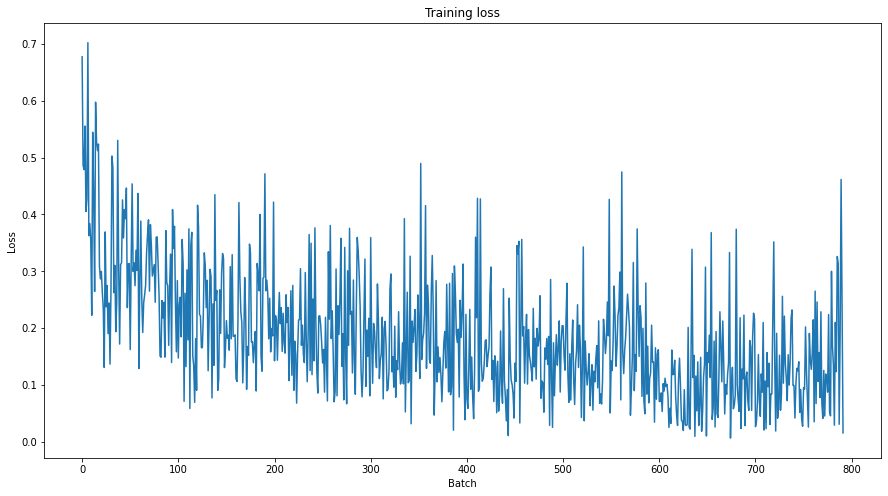

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
directory_path='/content/'

In [ ]:
torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')

In [ ]:
%%time
# torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()

CPU times: user 16.7 s, sys: 13.9 s, total: 30.6 s
Wall time: 30.6 s


In [ ]:
print('Test Accuracy of the model on vla data is: {} %'.format(100 * correct / total))

Test Accuracy of the model on vla data is: 90.59343434343434 %
